In [208]:
import numpy as np
from numpy import *
import pandas as pd
import h5py
import os
import re
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.signal as signal
import scipy.io as sio
import scipy.stats
from scipy.fft import fft
import neurokit2 as nk
import heartpy as hp
import nolds
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import warnings

In [209]:
## Open the data
file_path = '/Users/jinyanwei/Desktop/BP_Model/UCI_Cuffless_BloodPressureEstimation_DataSet /Part_1.mat'  # Replace with the path to your .mat file

with h5py.File(file_path, 'r') as f:
    print(list(f.keys()))  # List all the variables in the file

    # Access a specific variable and convert it to a NumPy array
    variable_name = 'Part_1'  # Replace with the name of the variable you want to access
    references = np.array(f[variable_name])

    # Dereference the objects and store them in a list
    data = []
    for ref in references.flat:
        dereferenced_object = np.array(f[ref])
        data.append(dereferenced_object)

# for i, array in enumerate(data):
#    print(f"Shape of data[{i}]: {array.shape}")

['#refs#', 'Part_1']


In [245]:
Include_Data = []
df = pd.DataFrame(columns=(('PPG','BP', 'ECG')))

for patient in range(300):
    if len(data[patient]) > 7499:
        data_df = pd.DataFrame(data[patient][:1000], columns=(('PPG','BP', 'ECG')))
        df = pd.concat([df, data_df])
        Include_Data.append(patient)

df

,PPG,BP,ECG
0,1.759531,67.062955,-0.060606
1,1.718475,69.358628,-0.075269
2,1.684262,75.366453,-0.070381
3,1.657869,85.037586,-0.035191
4,1.637341,96.222885,0.024438
...,...,...,...
995,1.108504,126.896859,-0.794922
996,1.109482,125.607376,-0.794922
997,1.110459,123.731764,-0.789062
998,1.110459,121.328636,-0.785156


### many times data

In [223]:
RMSE_SBP, RMSE_DBP, MAE_SBP, MAE_DBP, Abnormal_location= [], [], [], [], []

for patient in range(10):
    if len(data[patient]) > 999:
        df = pd.DataFrame(data[patient], columns=(('PPG','BP', 'ECG'))) #选取前10000条数据
        ecg_data = df['ECG']
        ppg_data = df['PPG']
        bp_data = df['BP']

        ## Filter signals

        # Define the sampling rate (e.g., 1000 Hz)
        sampling_rate = 1000

        # Filter ECG data
        ecg_filtered = nk.signal_filter(ecg_data, lowcut=0.5, highcut=50, method='butterworth', order=2, sampling_rate=sampling_rate)

        # Filter PPG data
        ppg_filtered = nk.signal_filter(ppg_data, lowcut=0.5, highcut=50, method='butterworth', order=2, sampling_rate=sampling_rate)

        ecg_df = pd.DataFrame(ecg_data)
        ecg_fildf = pd.DataFrame(ecg_filtered, columns=['ECG Filtered'])
        dfecg = pd.concat([ecg_df,ecg_fildf], axis=1)
        #display(dfecg)
        figecg = px.line(dfecg)
        #figecg.show()

        ppg_df = pd.DataFrame(ppg_data)
        ppg_fildf = pd.DataFrame(ppg_filtered, columns=['PPG Filtered'])
        dfppg = pd.concat([ppg_df,ppg_fildf], axis=1)
        #display(dfppg)
        figecg = px.line(dfppg)
        #figecg.show()

        dffilt = pd.concat([df['BP'],ecg_fildf, ppg_fildf], axis=1)
        # display(dffilt)

        ## Segment and gain one-beat data

        fs = 125

        # Find peaks in the PPG signal
        ppgpeaks, _ = signal.find_peaks(ppg_filtered, distance=fs//2.5)
        #print(ppgpeaks, len(ppgpeaks))
        '''plt.figure(figsize=(50, 10))
        for index in ppgpeaks:
            plt.scatter(index, ppg_filtered[index], marker="*")
        plt.plot(ppg_filtered)
        plt.show()'''

        # Find peaks in the ECG signal
        ecgpeaks, _ = signal.find_peaks(ecg_filtered, distance=fs//2.5)
        #print(ecgpeaks, len(ecgpeaks))
        '''plt.figure(figsize=(50, 10))
        for index in ecgpeaks:
            plt.scatter(index, ecg_filtered[index], marker="*")
        plt.plot(ecg_filtered)
        plt.show()'''

        # Calculate pulse rate (in beats per minute)
        ppg_pulse_rate = 60 * fs / np.mean(np.diff(ppgpeaks))
        ecg_pulse_rate = 60 * fs / np.mean(np.diff(ecgpeaks))
        #print('ppg_pulse_rate:' , ppg_pulse_rate)
        #print('ecg_pulse_rate:' , ecg_pulse_rate)

        ''' # Calculate peak-to-peak time intervals
        peak_to_peak_intervals = np.diff(peaks) / fs

        # Calculate pulse width at half-maximum amplitude
        pulse_widths = signal.peak_widths(ppg_filtered, peaks, rel_height=0.5)[0] / fs

        # Calculate area under the curve
        auc = np.trapz(ppg_filtered, dx=1/fs)

        # Calculate power spectral density (PSD) and peak frequency
        freqs, psd = signal.welch(ppg_filtered, fs)
        peak_frequency = freqs[np.argmax(psd)]

        # Calculate spectral entropy
        spectral_entropy = -np.sum(psd * np.log2(psd))

        # Compile features into a dictionary
        features = {
            'pulse_rate': pulse_rate,
            'mean_peak_to_peak_interval': np.mean(peak_to_peak_intervals),
            'std_peak_to_peak_interval': np.std(peak_to_peak_intervals),
            'mean_pulse_width': np.mean(pulse_widths),
            'std_pulse_width': np.std(pulse_widths),
            'area_under_curve': auc,
            'peak_frequency': peak_frequency,
            'spectral_entropy': spectral_entropy
        }'''

        # print(features)

        SBP, DBP, bplist = [], [], []

        for i in range(len(ecgpeaks)-1):
            peak_front = ecgpeaks[i]
            peak_back = ecgpeaks[i+1]
            bplist = bp_data[peak_front:peak_back]
            SBP.append(max(bplist))
            DBP.append(min(bplist))

        sbp_values = np.array(SBP)
        dpb_values = np.array(DBP)
        bp_df = pd.DataFrame(columns=(('SBP','DBP')))
        bp_df['SBP'] = sbp_values
        bp_df['DBP'] = dpb_values
        bp_values = bp_df.values

        def segment_signal(signal, rpeaks, window=15):
            segments = []
            for rpeak in rpeaks:
                start = max(0, rpeak - window)
                end = min(len(signal), rpeak + window)
                segment = signal[start:end]
                segments.append(segment)
            return segments

        # Assuming you have `ecg_signal`, `ppg_signal`, and `rpeaks`
        ecg_segments = segment_signal(ecg_data, ecgpeaks[:len(ecgpeaks)-1])
        ppg_segments = segment_signal(ppg_data, ppgpeaks[:len(ppgpeaks)-1])

        ## Extract features

        def extract_features(signal):
            '''# Chaotic features
            lyap_r = nolds.lyap_r(signal)
            hurst_exp = nolds.hurst_rs(signal)
            corr_dim = nolds.corr_dim(signal, 1)'''

            # Time domain features
            mean = np.mean(signal)
            std_dev = np.std(signal)
            skewness = scipy.stats.skew(signal)
            kurtosis = scipy.stats.kurtosis(signal)

            # Frequency domain features
            fft_values = fft(signal)
            power_spectrum = np.abs(fft_values)**2
            total_power = np.sum(power_spectrum)
            low_freq_power = np.sum(power_spectrum[:len(power_spectrum)//2]) / total_power
            high_freq_power = np.sum(power_spectrum[len(power_spectrum)//2:]) / total_power

            features = {
                #'lyap_r': lyap_r,
                #'hurst_exp': hurst_exp,
                #'corr_dim': corr_dim,
                'mean': mean,
                'std_dev': std_dev,
                'skewness': skewness,
                'kurtosis': kurtosis,
                'low_freq_power': low_freq_power,
                'high_freq_power': high_freq_power
            }

            return features

        # Assuming `ecg_signal` and `ppg_signal` are your signals
        ecg_features = extract_features(ecg_filtered)
        ppg_features = extract_features(ppg_filtered)

        warnings.filterwarnings("ignore", category=RuntimeWarning, module='nolds')

        from numpy.fft import fft

        ecg_feature_list = [extract_features(segment) for segment in ecg_segments]
        ppg_feature_list = [extract_features(segment) for segment in ppg_segments]

        ecg_features_df = pd.DataFrame(ecg_feature_list)
        ppg_features_df = pd.DataFrame(ppg_feature_list)

        # Concatenate ECG and PPG features
        features_df = pd.concat([ecg_features_df, ppg_features_df], axis=1)
        features_data = features_df.values

        beatdf = pd.concat([features_df, bp_df], axis=1)
        beatdf.dropna(inplace=True)
        features_df = beatdf.iloc[:, :-2]
        bp_df = beatdf.iloc[:, -2:]

        ## Random Forest Model

        X_scaled = features_df.values
        y = bp_df

        # Split into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

        # Initialize the random forest model
        model = RandomForestRegressor(n_estimators=100, random_state=42)

        # Train the model on the training data
        model.fit(X_train, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Calculate root mean squared error and mean absolute error for both SBP and DBP
        rmse_sbp = metrics.mean_squared_error(y_test["SBP"], y_pred[:, 0])**0.5
        rmse_dbp = metrics.mean_squared_error(y_test["DBP"], y_pred[:, 1])**0.5
        mae_sbp = metrics.mean_absolute_error(y_test["SBP"], y_pred[:, 0])
        mae_dbp = metrics.mean_absolute_error(y_test["DBP"], y_pred[:, 1])

        if rmse_sbp > 5 or rmse_dbp >5:
            Abnormal_location.append(patient)

        RMSE_SBP.append(rmse_sbp)
        RMSE_DBP.append(rmse_dbp)
        MAE_SBP.append(mae_sbp)
        MAE_DBP.append(mae_dbp)

print('RMSE_SBP: ', RMSE_SBP)
print('RMSE_DBP: ', RMSE_DBP)
print('MAE_SBP: ', MAE_SBP)
print('MAE_DBP: ', MAE_DBP)
print('Abnormal location: ', Abnormal_location)
print('RMSE_SBP: ', mean(RMSE_SBP), 'RMSE_DBP', mean(RMSE_DBP), 'MAE_SBP: ', mean(MAE_SBP), 'MAE_DBP', mean(MAE_DBP))

RMSE_SBP:  [5.568002492549614, 2.1289120457721644, 4.940488319774102, 1.938265512651024, 3.2376474542224005, 1.6345686933116435, 3.28983402362423, 1.5457142218739592, 1.3040693164000372, 2.101256656703515]
RMSE_DBP:  [3.3516592964002165, 1.766151824562691, 4.656524120136066, 1.1615397859278562, 2.465371123864669, 0.9293462874764727, 1.292943660843421, 0.7659482362213927, 0.4688983554596899, 1.5307314458483594]
MAE_SBP:  [4.251268111989072, 1.6763777434980418, 3.2112253073499235, 1.5671575097687651, 2.5038862357486056, 1.3023679861968145, 2.6072440148334035, 1.2594452286637032, 0.936015851539968, 1.7406410625872013]
MAE_DBP:  [2.598535801022566, 1.3464927617466338, 2.8316619232018128, 0.9138999548292445, 1.8412607355475394, 0.7613915060743224, 0.9380215273192726, 0.6111211512880802, 0.3112183510555961, 1.363564577604322]
Abnormal location:  [0]
RMSE_SBP:  2.768875873688269 RMSE_DBP 1.8389114136740834 MAE_SBP:  2.10556290521755 MAE_DBP 1.351716828968939


### For one patient:

In [249]:
ecg_df

,ECG
0,-0.060606
1,-0.075269
2,-0.070381
3,-0.035191
4,0.024438
...,...
995,-0.794922
996,-0.794922
997,-0.789062
998,-0.785156


In [251]:
# df = pd.DataFrame(data[5], columns=(('PPG','BP', 'ECG'))) #选取前1000条数据
# df.to_csv('Part_1_data_0.csv')
# display(df)
figdf = px.line(df)
# figdf.show()

ecg_data = df['ECG']
ppg_data = df['PPG']
bp_data = df['BP']

## Filter signals

# Define the sampling rate (e.g., 1000 Hz)
sampling_rate = 1000

# Filter ECG data
ecg_filtered = nk.signal_filter(ecg_data, lowcut=0.5, highcut=50, method='butterworth', order=2, sampling_rate=sampling_rate)

# Filter PPG data
ppg_filtered = nk.signal_filter(ppg_data, lowcut=0.5, highcut=50, method='butterworth', order=2, sampling_rate=sampling_rate)

ecg_df = pd.DataFrame(ecg_data)
ecg_fildf = pd.DataFrame(ecg_filtered, columns=['ECG Filtered'])
#dfecg = pd.concat([ecg_df,ecg_fildf], axis=1)
#display(dfecg)
figecg = px.line(dfecg)
#figecg.show()

ppg_df = pd.DataFrame(ppg_data)
ppg_fildf = pd.DataFrame(ppg_filtered, columns=['PPG Filtered'])
#dfppg = pd.concat([ppg_df,ppg_fildf], axis=1)
#display(dfppg)
figecg = px.line(dfppg)
#figecg.show()

#dffilt = pd.concat([df['BP'],ecg_fildf, ppg_fildf], axis=1)
# display(dffilt)


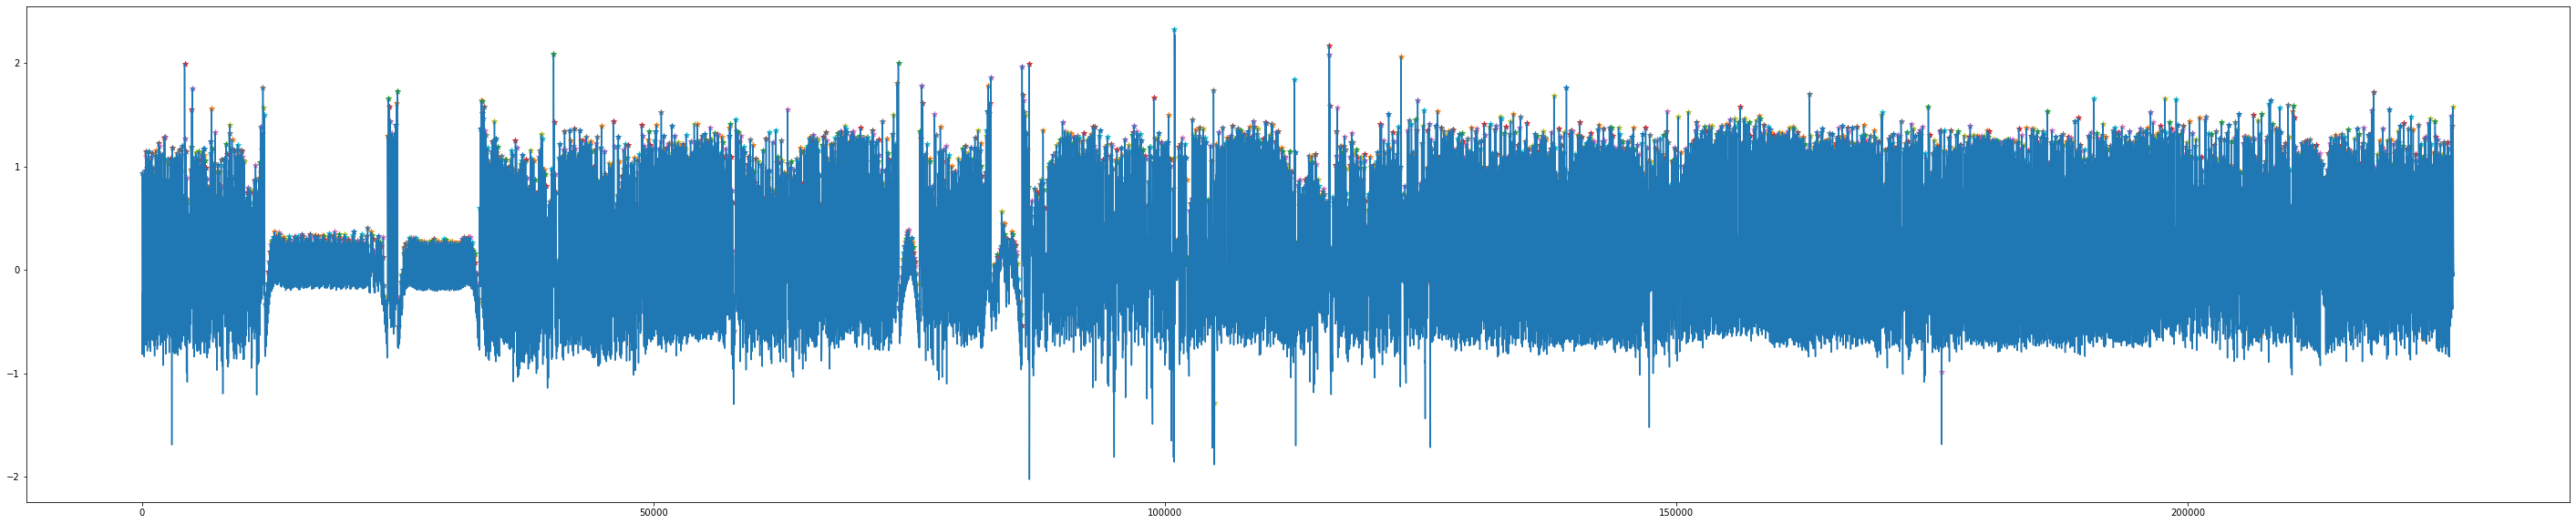

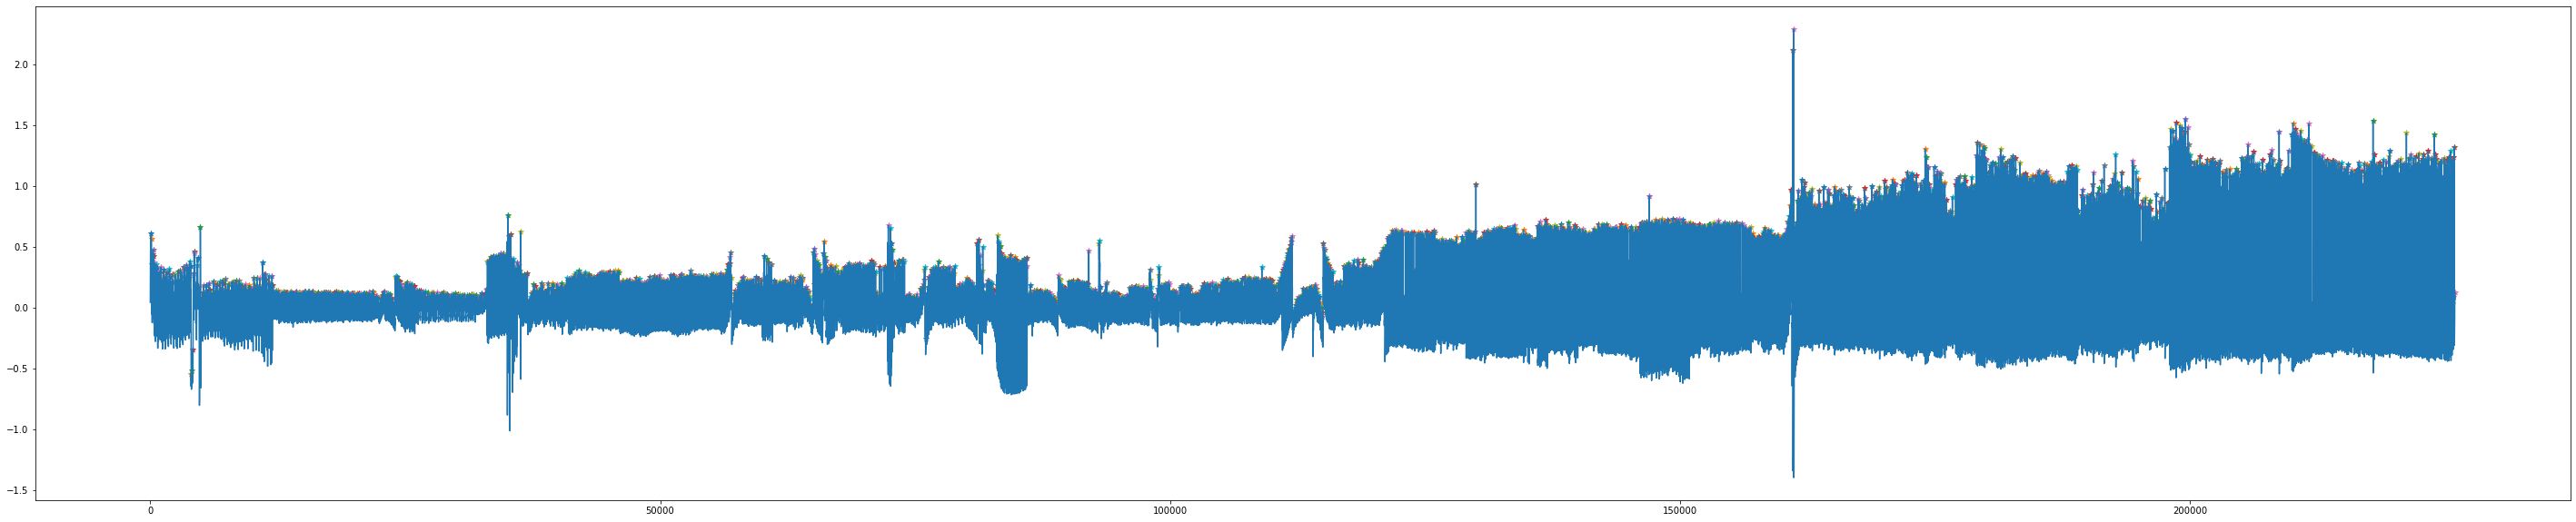

In [252]:

## Segment and gain one-beat data

fs = 125

# Find peaks in the PPG signal
ppgpeaks, _ = signal.find_peaks(ppg_filtered, distance=fs//2.5)
#print(ppgpeaks, len(ppgpeaks))
plt.figure(figsize=(50, 10))
for index in ppgpeaks:
    plt.scatter(index, ppg_filtered[index], marker="*")
plt.plot(ppg_filtered)
#plt.show()

# Find peaks in the ECG signal
ecgpeaks, _ = signal.find_peaks(ecg_filtered, distance=fs//2.5)
#print(ecgpeaks, len(ecgpeaks))
plt.figure(figsize=(50, 10))
for index in ecgpeaks:
    plt.scatter(index, ecg_filtered[index], marker="*")
plt.plot(ecg_filtered)
#plt.show()

# Calculate pulse rate (in beats per minute)
ppg_pulse_rate = 60 * fs / np.mean(np.diff(ppgpeaks))
ecg_pulse_rate = 60 * fs / np.mean(np.diff(ecgpeaks))
#print('ppg_pulse_rate:' , ppg_pulse_rate)
#print('ecg_pulse_rate:' , ecg_pulse_rate)

''' # Calculate peak-to-peak time intervals
peak_to_peak_intervals = np.diff(peaks) / fs

# Calculate pulse width at half-maximum amplitude
pulse_widths = signal.peak_widths(ppg_filtered, peaks, rel_height=0.5)[0] / fs

# Calculate area under the curve
auc = np.trapz(ppg_filtered, dx=1/fs)

# Calculate power spectral density (PSD) and peak frequency
freqs, psd = signal.welch(ppg_filtered, fs)
peak_frequency = freqs[np.argmax(psd)]

# Calculate spectral entropy
spectral_entropy = -np.sum(psd * np.log2(psd))

# Compile features into a dictionary
features = {
    'pulse_rate': pulse_rate,
    'mean_peak_to_peak_interval': np.mean(peak_to_peak_intervals),
    'std_peak_to_peak_interval': np.std(peak_to_peak_intervals),
    'mean_pulse_width': np.mean(pulse_widths),
    'std_pulse_width': np.std(pulse_widths),
    'area_under_curve': auc,
    'peak_frequency': peak_frequency,
    'spectral_entropy': spectral_entropy
}'''

# print(features)

SBP, DBP, bplist = [], [], []

for i in range(len(ecgpeaks)-1):
    peak_front = ecgpeaks[i]
    peak_back = ecgpeaks[i+1]
    bplist = bp_data[peak_front:peak_back]
    SBP.append(max(bplist))
    DBP.append(min(bplist))

sbp_values = np.array(SBP)
dpb_values = np.array(DBP)
bp_df = pd.DataFrame(columns=(('SBP','DBP')))
bp_df['SBP'] = sbp_values
bp_df['DBP'] = dpb_values
bp_values = bp_df.values

def segment_signal(signal, rpeaks, window=15):
    segments = []
    for rpeak in rpeaks:
        start = max(0, rpeak - window)
        end = min(len(signal), rpeak + window)
        segment = signal[start:end]
        segments.append(segment)
    return segments

# Assuming you have `ecg_signal`, `ppg_signal`, and `rpeaks`
ecg_segments = segment_signal(ecg_data, ecgpeaks[:len(ecgpeaks)-1])
ppg_segments = segment_signal(ppg_data, ppgpeaks[:len(ppgpeaks)-1])

## Extract features

def extract_features(signal):
    '''# Chaotic features
    lyap_r = nolds.lyap_r(signal)
    hurst_exp = nolds.hurst_rs(signal)
    corr_dim = nolds.corr_dim(signal, 1)'''

    # Time domain features
    mean = np.mean(signal)
    std_dev = np.std(signal)
    skewness = scipy.stats.skew(signal)
    kurtosis = scipy.stats.kurtosis(signal)

    # Frequency domain features
    fft_values = fft(signal)
    power_spectrum = np.abs(fft_values)**2
    total_power = np.sum(power_spectrum)
    low_freq_power = np.sum(power_spectrum[:len(power_spectrum)//2]) / total_power
    high_freq_power = np.sum(power_spectrum[len(power_spectrum)//2:]) / total_power

    features = {
        #'lyap_r': lyap_r,
        #'hurst_exp': hurst_exp,
        #'corr_dim': corr_dim,
        'mean': mean,
        'std_dev': std_dev,
        'skewness': skewness,
        'kurtosis': kurtosis,
        'low_freq_power': low_freq_power,
        'high_freq_power': high_freq_power
    }

    return features

# Assuming `ecg_signal` and `ppg_signal` are your signals
ecg_features = extract_features(ecg_filtered)
ppg_features = extract_features(ppg_filtered)

warnings.filterwarnings("ignore", category=RuntimeWarning, module='nolds')

from numpy.fft import fft

ecg_feature_list = [extract_features(segment) for segment in ecg_segments]
ppg_feature_list = [extract_features(segment) for segment in ppg_segments]

ecg_features_df = pd.DataFrame(ecg_feature_list)
ppg_features_df = pd.DataFrame(ppg_feature_list)

# Concatenate ECG and PPG features
features_df = pd.concat([ecg_features_df, ppg_features_df], axis=1)
features_data = features_df.values

In [253]:
beatdf = pd.concat([features_df, bp_df], axis=1)
beatdf.dropna(inplace=True)
features_df = beatdf.iloc[:, :-2]
bp_df = beatdf.iloc[:, -2:]

## Random Forest Model

X_scaled = features_df.values
y = bp_df

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the random forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate root mean squared error and mean absolute error for both SBP and DBP
rmse_sbp = metrics.mean_squared_error(y_test["SBP"], y_pred[:, 0])**0.5
rmse_dbp = metrics.mean_squared_error(y_test["DBP"], y_pred[:, 1])**0.5
mae_sbp = metrics.mean_absolute_error(y_test["SBP"], y_pred[:, 0])
mae_dbp = metrics.mean_absolute_error(y_test["DBP"], y_pred[:, 1])

print(f"Root mean squared error for SBP: {rmse_sbp:.3f}")
print(f"Root mean squared error for DBP: {rmse_dbp:.3f}")
print(f"Mean absolute error for SBP: {mae_sbp:.3f}")
print(f"Mean absolute error for DBP: {mae_dbp:.3f}")


Root mean squared error for SBP: 13.613
Root mean squared error for DBP: 7.028
Mean absolute error for SBP: 9.311
Mean absolute error for DBP: 4.312


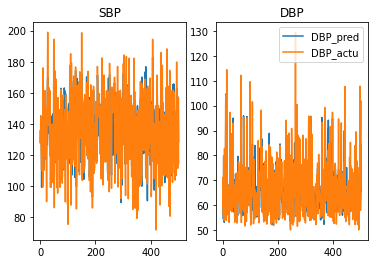

In [254]:
## Visualization

# gain BP result df

estimate_bp_df = pd.DataFrame()
estimate_bp_df['SBP_actu'] = y_test['SBP']
estimate_bp_df['SBP_pred'] = y_pred[:, 0]
estimate_bp_df['DBP_actu'] = y_test['DBP']
estimate_bp_df['DBP_pred'] = y_pred[:, 1]
estimate_bp_df.reset_index(drop=True)

# Draw pictures

plt.figure()

plt.subplot(1, 2, 1)
x1 = np.array((range(len(estimate_bp_df))))
sbp1 = np.array(estimate_bp_df['SBP_pred'])
sbp2 = np.array(estimate_bp_df['SBP_actu'])
plt.plot(x1, sbp1, label='SBP_pred')
plt.plot(x1, sbp2, label='SBP_actu')
plt.title('SBP')

plt.subplot(1, 2, 2)
x2 = np.array((range(len(estimate_bp_df))))
dbp1 = np.array(estimate_bp_df['DBP_pred'])
dbp2 = np.array(estimate_bp_df['DBP_actu'])
plt.plot(x1, dbp1, label='DBP_pred')
plt.plot(x1, dbp2, label='DBP_actu')
plt.title('DBP')

plt.legend()
plt.show()